## 0-Librairies

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.config import run_functions_eagerly

In [26]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [27]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [28]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [29]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## 2 - Data Viz

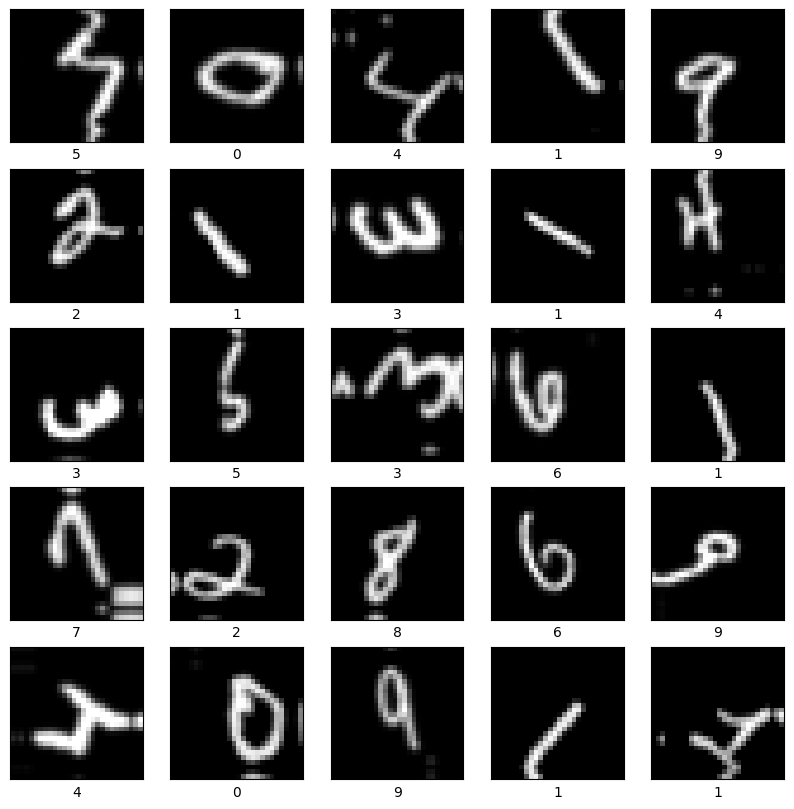

In [30]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

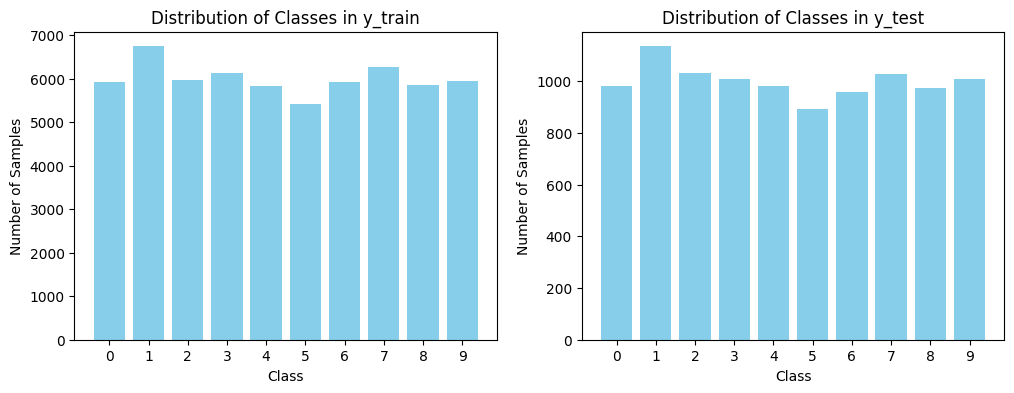

In [31]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - Dense Modele

### Parameters

In [48]:
# Parameters
epochs_dense = 5 #epochs_dense = 50
batch_size_dense = 128
validation_split_dense = .2
early_stop_dense = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
k_folds_dense = 2

### Change shape of data

In [49]:
# Flatten images for dense model
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

### Modele

In [ ]:
# Create and compile the dense model
# dense_model = Sequential([
#     Dense(256, activation='relu', input_shape=(784,)),
#     Dropout(0.3),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(10, activation='softmax')
# ])

# dense_model.compile(optimizer=opt_dense,
#                     loss='sparse_categorical_crossentropy',
#                     metrics=['accuracy'])

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
def create_dense_model():
    dense_model = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

    dense_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
        )
    return dense_model

In [ ]:
# Train the dense model
# dense_history = dense_model.fit(X_train_flat, y_train,
#                                 epochs=epochs_dense,
#                                 batch_size=batch_size_dense,
#                                 validation_split=validation_split_dense,
#                                 callbacks=[early_stop_dense])

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.2178 - loss: 2.1426 - val_accuracy: 0.3093 - val_loss: 1.9498


In [51]:
skf = StratifiedKFold(n_splits=k_folds_dense, shuffle=True)
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_cnn_history = None

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_flat, y_train)):
    print(f"\nFold {fold + 1}/{k_folds_dense}")


    X_train_fold, X_val_fold = X_train_flat[train_idx], X_train_flat[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    dense_model = create_dense_model()

    # Train the model
    history = dense_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_dense,
        batch_size=batch_size_dense,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop_dense],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = dense_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    # Kepp the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dense_model = dense_model
        best_dense_history = history

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_dense_model.summary()


Fold 1/2
Epoch 1/5


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.1486 - loss: 2.2644 - val_accuracy: 0.1978 - val_loss: 2.1851
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.2087 - loss: 2.1542 - val_accuracy: 0.2306 - val_loss: 2.1172
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.2366 - loss: 2.0954 - val_accuracy: 0.2489 - val_loss: 2.0612
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.2614 - loss: 2.0429 - val_accuracy: 0.2803 - val_loss: 2.0010
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.2806 - loss: 1.9944 - val_accuracy: 0.2987 - val_loss: 1.9557
Validation accuracy for fold 1: 0.2987

Fold 2/2
Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.1507 - loss: 2.2632 - val_accuracy: 0.1953 - val_loss: 2.1856
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.2100 - loss: 2.1595 - val_accuracy: 0.2304 - val_loss: 2.1108
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - acc

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,440 (2.69 MB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,294 (1.79 MB)

### Results

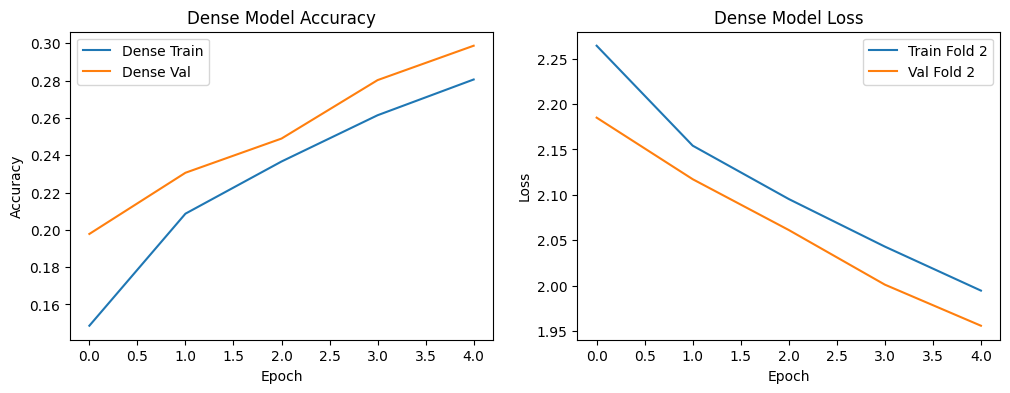

In [52]:
# summarize history for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_dense_history.history['accuracy'], label='Dense Train')
plt.plot(best_dense_history.history['val_accuracy'], label='Dense Val')
plt.title('Dense Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(best_dense_history.history['loss'], label=f'Train Fold {i+1}')
plt.plot(best_dense_history.history['val_loss'], label=f'Val Fold {i+1}')
plt.title('Dense Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [53]:
# Predict classes using the dense model
y_pred_dense = best_dense_model.predict(X_test_flat)
y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


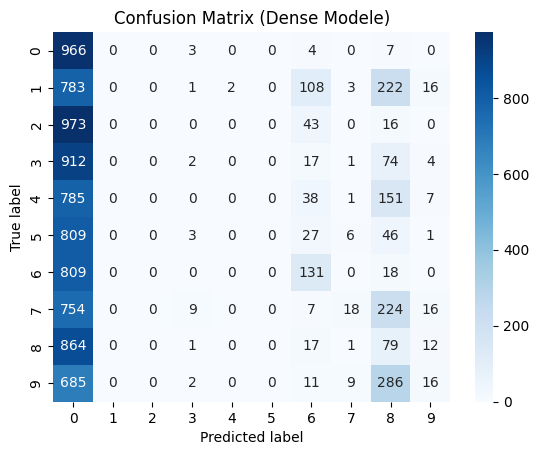

Class 0:
  Sensitivity (SEV): 0.9857
  Specificity (SPE): 0.1825

  F1-score: 0.2073

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 3:
  Sensitivity (SEV): 0.0020
  Specificity (SPE): 0.9979

  F1-score: 0.0039

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9998

  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.1367
  Specificity (SPE): 0.9699

  F1-score: 0.1925

Class 7:
  Sensitivity (SEV): 0.0175
  Specificity (SPE): 0.9977

  F1-score: 0.0337

Class 8:
  Sensitivity (SEV): 0.0811
  Specificity (SPE): 0.8843

  F1-score: 0.0753

Class 9:
  Sensitivity (SEV): 0.0159
  Specificity (SPE): 0.9938

  F1-score: 0.0296



In [54]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_dense)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Dense Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}\n')
    print(f'  F1-score: {f1:.4f}\n')

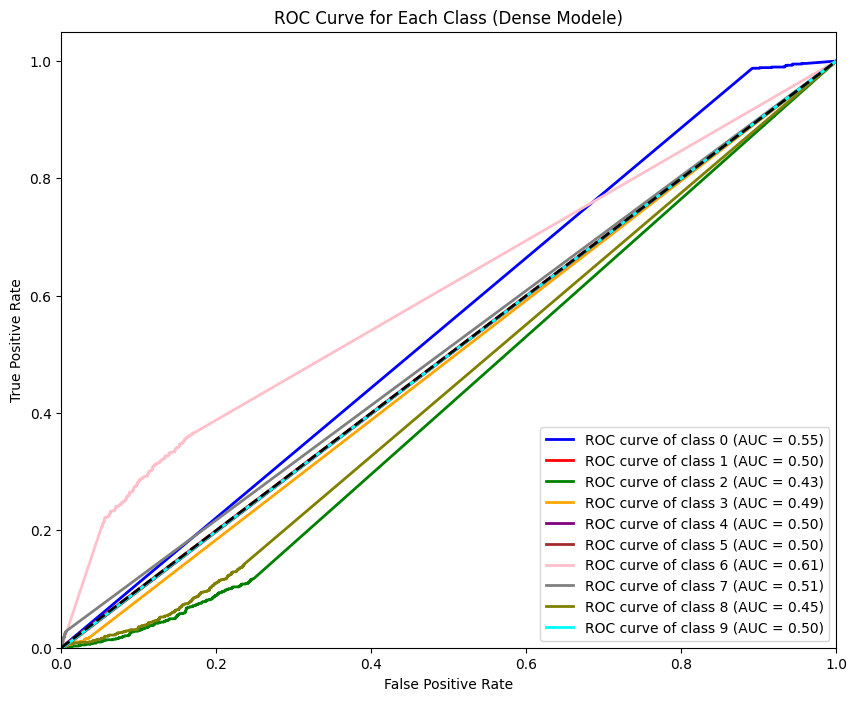

In [40]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Dense Modele)')
plt.legend(loc="lower right")
plt.show()

## 4 - CNN Modele

### Parameters

In [ ]:
# Parameters
epochs_cnn = 5
batch_size_cnn = 50
validation_split_cnn = .2
early_stop_cnn = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
k_folds = 5 

### Change shape of data

In [42]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

### Modele

In [ ]:
def create_cnn_model():
    cnn_model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(50, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
        ])

    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
        )
    return cnn_model

In [47]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_cnn_history = None

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cnn, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")


    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    cnn_model = create_cnn_model()

    # Train the model
    history = cnn_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_cnn,
        batch_size=batch_size_cnn,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop_cnn],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    # Kepp the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_cnn_model = cnn_model
        best_cnn_history = history

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_cnn_model.summary()


Fold 1/5


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 109s 114ms/step - accuracy: 0.4862 - loss: 1.4703 - val_accuracy: 0.7546 - val_loss: 0.7893
Epoch 2/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 110s 114ms/step - accuracy: 0.7281 - loss: 0.8287 - val_accuracy: 0.8212 - val_loss: 0.5902
Epoch 3/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 111s 115ms/step - accuracy: 0.7923 - loss: 0.6419 - val_accuracy: 0.8163 - val_loss: 0.6022
Epoch 4/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 111s 115ms/step - accuracy: 0.8224 - loss: 0.5471 - val_accuracy: 0.8532 - val_loss: 0.4778
Epoch 5/5
960/960 ━━━━━━━━━━━━━━━━━━━━ 114s 118ms/step - accuracy: 0.8439 - loss: 0.4876 - val_accuracy: 0.5834 - val_loss: 1.6752
Validation accuracy for fold 1: 0.8532

Fold 2/5
Epoch 1/5


ValueError: Unknown variable: <Variable path=sequential_5/conv2d_6/kernel, shape=(3, 3, 1, 64), dtype=float32, value=[[[[ 0.80901086  0.24834418 -0.311904    0.63263774  0.23609293
     0.327945   -0.05831277 -0.25362104  0.7584828  -0.1165781
    -0.330919   -0.7824749  -0.09096408  0.00564539  0.72581613
    -0.534486    0.5859978   0.14664084 -0.02928817  0.4179213
     0.4376917   0.6173593   0.6427864  -0.3298929   0.3118117
     0.65227973  0.6421796   0.7882966  -0.8046499   0.3496753
     0.46615565  0.20384467 -0.39398634 -0.5873909  -0.24749655
     0.02174497  0.79598737  0.7057358   0.52833414 -0.2941501
     0.38451946  0.28384793  0.54863715  0.22491741  0.7138096
     0.0777601   0.39868057  0.37356877 -0.26042467  0.79683363
    -0.38090292  0.6201047   0.5566577  -0.23836958 -0.5165436
     0.02736819 -0.7212181  -0.2424013  -0.14669752  0.40836573
    -0.31009108  0.5397271  -0.71136266 -0.08137411]]

  [[ 0.42948174  0.73912954  0.1939745  -0.12651938  0.37407124
     0.07677138  0.29213917  0.5249245  -0.34203726 -0.29008853
     0.35318124  0.5110537   0.44592476  0.27264202 -0.19015574
     0.69095933 -0.22399098  0.09367305 -0.09541243  0.09922791
    -0.3392679   0.38028467  0.03973794  0.04215127 -0.29635042
     0.04956734  0.53635263  0.29107392 -0.504226   -0.60897255
     0.55228686  0.5783521   0.37543643 -0.75594455 -0.78912807
    -0.13612741 -0.22724837  0.12401986 -0.05830848 -0.45363396
    -0.31140506  0.37690973  0.2792858  -0.5775187  -0.47077274
     0.11987281 -0.7502828   0.3564458  -0.16040117 -0.610673
     0.2074312   0.07556736 -0.48318827 -0.30795676 -0.6572444
    -0.04880017  0.06325364 -0.15928805  0.17829716  0.3951758
    -0.12271148  0.32105708 -0.64877164 -0.00996876]]

  [[ 0.6972915   0.5513388   0.056005   -0.18124521  0.7426896
     0.3938625  -0.22070229  0.7617252   0.11421639  0.16283
     0.43417048  0.16267663 -0.40900302 -0.569361    0.47654712
     0.63414276 -0.06186199  0.5685959  -0.41144806 -0.55879885
    -0.21391481 -0.07699877 -0.3332665   0.11722904  0.04689437
    -0.24268866 -0.34795028  0.00175476  0.4565333   0.73841846
     0.5690737   0.8017318   0.64246476 -0.7784178  -0.40526307
    -0.7691193  -0.67633843  0.6062807  -0.11335593 -0.7338367
    -0.4194493  -0.06561577 -0.42371118  0.6858654  -0.7142839
    -0.5549682  -0.32451636  0.76320076 -0.6714094  -0.69413435
     0.7421807   0.53935015 -0.04798895  0.7644727  -0.75396323
    -0.35057092  0.6746055   0.39482045 -0.3540399  -0.01179749
    -0.20864105 -0.46661112 -0.77385867  0.14924455]]]


 [[[-0.7549406  -0.03405893  0.42541933 -0.13688427 -0.01082528
     0.05923647  0.26425374  0.7599572   0.02658272 -0.57485896
    -0.6494546  -0.690585   -0.36382526 -0.6834998  -0.5213825
    -0.8156535   0.2934004   0.10163403 -0.42099944  0.6002265
     0.30228817  0.27980733 -0.12715441  0.04452467 -0.74389696
    -0.04868644  0.76491404 -0.4946324  -0.07828319 -0.04024976
     0.48726964 -0.46237436  0.27575696 -0.311853   -0.0037933
    -0.17683733  0.6092441   0.6257268  -0.67288655  0.7404965
     0.28241122  0.5278652   0.790702   -0.7008847  -0.42543224
     0.2782284  -0.80943817  0.54441345 -0.32893923 -0.51578075
    -0.0768553   0.56753266 -0.37234783 -0.34519303 -0.24732041
    -0.7290652   0.29661226 -0.1282599  -0.3878407  -0.5431571
     0.10393459 -0.6001687  -0.42148164 -0.01247936]]

  [[ 0.16166222  0.21091902  0.432822    0.35392582  0.5146203
     0.1250171   0.15383929 -0.20353293  0.06601912  0.27437472
     0.76325595  0.33309913 -0.43825772 -0.11269039  0.04221666
    -0.7428915  -0.5789635  -0.26069468  0.5820749   0.3766731
     0.46326172 -0.6019032  -0.07263547  0.586534    0.4308201
     0.6096703  -0.70821005  0.15146023 -0.6349094   0.4807831
     0.16673428 -0.41514987  0.62387204 -0.21664989 -0.41900098
     0.29254794  0.41730762 -0.800279   -0.60187185 -0.76409143
     0.62019086 -0.3788805   0.14206284 -0.8002409   0.13547605
    -0.7945087   0.7189865  -0.70317084 -0.48214564 -0.6102492
     0.12811685 -0.25253475  0.16519153 -0.5054567   0.79463875
    -0.4904229  -0.22553098 -0.64338446 -0.54890525  0.5305699
    -0.3526531  -0.5903008   0.2716912   0.06115842]]

  [[ 0.21866798  0.11674142 -0.61394167  0.49084258 -0.29262644
    -0.5707692  -0.47457966 -0.7564392   0.43935025 -0.65042555
    -0.7283708  -0.44154567 -0.40237635 -0.03542393  0.7740574
     0.5331844  -0.47588024 -0.47330868  0.54503775  0.14267701
     0.14878261 -0.17001969 -0.19999778 -0.33777013  0.6773783
    -0.60169786  0.7206205   0.5220498  -0.15799934 -0.04713106
    -0.00290191  0.6136018  -0.13410443  0.72343516  0.3552611
    -0.02076739  0.07690555 -0.4563278   0.6988052   0.70070267
     0.21983111 -0.11638653  0.5007191  -0.22250682 -0.48317328
    -0.4878385  -0.37408447 -0.02219099 -0.05395377 -0.18028939
    -0.2273755  -0.50783455 -0.01782262  0.29787135 -0.10456043
     0.39991808  0.12592876  0.4740132   0.38439584 -0.1120345
     0.374838   -0.5104408  -0.5370422   0.3754499 ]]]


 [[[-0.21637619  0.63530064  0.36854482 -0.1243459   0.12728423
     0.605518   -0.08394551 -0.511194   -0.591266   -0.28098565
     0.24766374  0.7603532   0.5747422   0.6085893  -0.59795845
     0.18453157  0.5853251  -0.5798372  -0.18908584 -0.7638687
     0.17575169  0.5073534  -0.6726691  -0.54287696  0.7859341
    -0.69765025 -0.01200169 -0.55387026 -0.15200728 -0.57064736
    -0.2658931   0.15548968 -0.7897901  -0.4199757  -0.11768401
     0.48697746  0.5529007  -0.36042482 -0.39886472 -0.38936493
    -0.14542395 -0.68328536 -0.6588471   0.48401332 -0.2378782
    -0.78090024 -0.0313279  -0.70781463 -0.4972571   0.08853769
    -0.00667673 -0.14593226 -0.19946712  0.17638415 -0.01932585
    -0.26066685  0.71169853  0.32290065 -0.23970264  0.513391
     0.43698323 -0.17920375 -0.7149278   0.6084608 ]]

  [[-0.36083964 -0.7935057   0.5364522   0.38069212 -0.693111
     0.18725312 -0.42969623 -0.17562944  0.6058694  -0.5879942
    -0.5076752   0.6917347  -0.43866265  0.6797428  -0.42740598
    -0.58674794  0.00942892 -0.7833892  -0.47880903  0.5463859
     0.24644327 -0.7515252   0.78968596 -0.11943501  0.5607823
     0.62198615 -0.03646111  0.33754587 -0.5102333  -0.11571378
     0.6123067   0.6472815   0.40551364 -0.2963286  -0.6323921
    -0.39717054 -0.02409834  0.1341936   0.0070762   0.44296968
     0.37836993  0.6753491  -0.4497005  -0.61720955  0.11416203
    -0.52295935  0.68560493 -0.23511082  0.6660714   0.303239
    -0.7539457   0.7062119  -0.39017844 -0.07427907  0.2856797
    -0.39145684  0.77444077  0.06345123  0.38552237 -0.4918292
     0.4952885   0.7046758  -0.10169649 -0.28464055]]

  [[ 0.41221893  0.3200785   0.7901255  -0.5710754  -0.4740188
     0.50847423 -0.5967764  -0.72871107  0.09175342 -0.4327792
     0.5352583  -0.48206678 -0.31883556 -0.4500081  -0.13495338
     0.0038926   0.75780475 -0.12575805 -0.31704286  0.53559303
    -0.66006786 -0.4254114  -0.4324792  -0.11960733 -0.5737694
    -0.51110446  0.18666267  0.23692632  0.68512416  0.46114695
     0.5959077  -0.03079551  0.64528286  0.10038674 -0.07397753
     0.5464772  -0.61483383  0.3079281   0.6816634   0.36090004
     0.5804323  -0.699938   -0.2025637   0.09372365  0.18219966
     0.790249    0.50490034  0.18858385 -0.4383023   0.56707406
    -0.18851376 -0.00555521 -0.07298142 -0.5253434  -0.13806826
    -0.47368574  0.72661865  0.50703895 -0.47831747  0.22265816
    -0.22259969  0.0852527   0.12831187  0.41069198]]]]>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

### Results

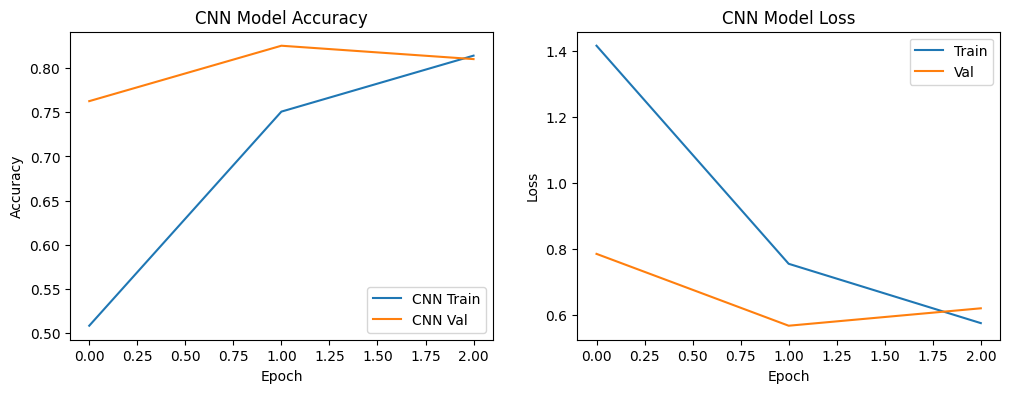

In [ ]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history['accuracy'], label='CNN Train')
plt.plot(best_cnn_history.history['val_accuracy'], label='CNN Val')
plt.title('Best CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['loss'], label='Train')
plt.plot(best_cnn_history.history['val_loss'], label='Val')
plt.title('Best CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict classes using the cnn model
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


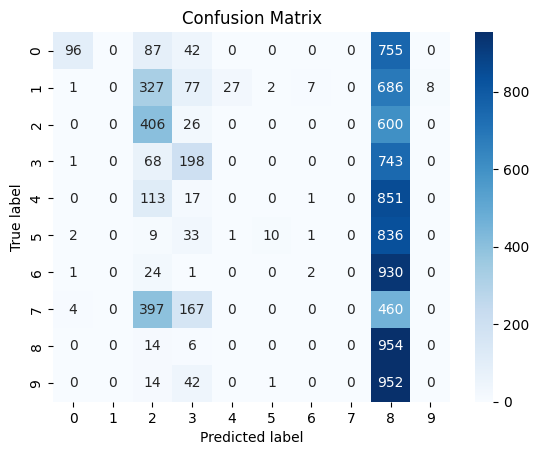

Class 0:
  Sensitivity (SEV): 0.0980
  Specificity (SPE): 0.9990

  F1-score: 0.1770

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.3934
  Specificity (SPE): 0.8826

  F1-score: 0.3260

Class 3:
  Sensitivity (SEV): 0.1960
  Specificity (SPE): 0.9543

  F1-score: 0.2446

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9969

  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0112
  Specificity (SPE): 0.9997

  F1-score: 0.0221

Class 6:
  Sensitivity (SEV): 0.0021
  Specificity (SPE): 0.9990

  F1-score: 0.0041

Class 7:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  F1-score: 0.0000

Class 8:
  Sensitivity (SEV): 0.9795
  Specificity (SPE): 0.2452

  F1-score: 0.2183

Class 9:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9991

  F1-score: 0.0000



In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_cnn)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (CNN Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}\n')
    print(f'  F1-score: {f1:.4f}\n')

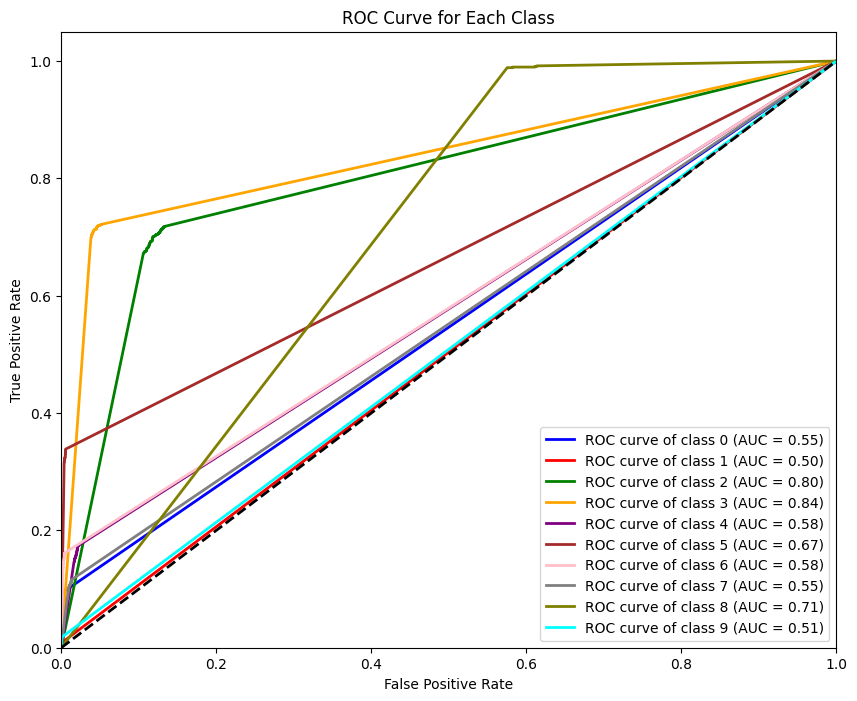

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (CNN Modele)')
plt.legend(loc="lower right")
plt.show()